In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from typing import List, Tuple, Union
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.element import Figure
from IPython.display import display
from tqdm.notebook import tqdm
import re
from functools import partial
import requests
from time import sleep

pd.set_option("display.max_rows", 20)

from opt_emergency.api import NaverMap, PublicDataPortal
from opt_emergency.calc import NearestEr

In [2]:
community_center_df = pd.read_csv("../data/processed/community_center_df.csv")
population_df = pd.read_csv("../data/processed/population_df.csv")
emergency_df = pd.read_csv("../data/processed/emergency_df.csv")
comm_pop_df = pd.read_csv("../data/processed/community_population_df.csv")

/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_8709/236628760.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


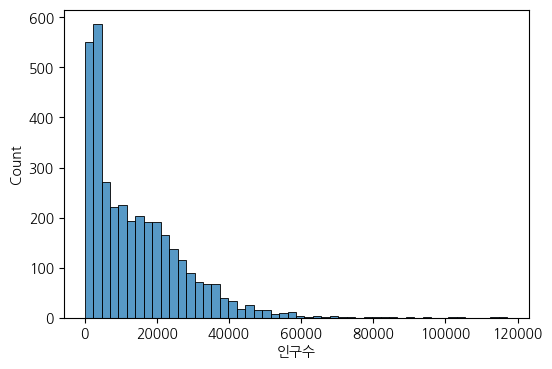

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams["font.family"] = "Nanum Gothic"
sns.histplot(comm_pop_df["인구수"], ax=ax)
fig.show()

In [5]:
residential_area_viz = folium.Map(
    location=[36, 127.7],
    tiles="cartodbpositron", 
    zoom_start=6,
)

fig = Figure(width=500, height=400)
fig.add_child(residential_area_viz)

for i in range(comm_pop_df.shape[0]):
    radius_resize = 0.03
    radius = np.sqrt(comm_pop_df["인구수"].iloc[i]) * radius_resize
    folium.CircleMarker(
        [comm_pop_df['위도'].iloc[i], comm_pop_df['경도'].iloc[i]], 
        radius=radius,
        color="green",
        stroke=False,
        fill=True,
        fill_opacity=0.5,
    ).add_to(residential_area_viz)

residential_area_viz

In [6]:
def create_white_background_map(
        center_loc: List[float] = [36, 127.7],
        zoom_start: int = 6,
) -> Tuple[Figure, folium.Map]:
    f_map = folium.Map(
        location=center_loc,
        tiles="cartodbpositron", 
        zoom_start=zoom_start,
    )
    fig = Figure(width=500, height=400)
    fig.add_child(f_map)
    return fig, f_map

def add_residential_layer(
        f_map: folium.Map,
        res_df: pd.DataFrame, 
        radius_weight=0.03, 
        color: str = "green",
) -> None:
    assert {"위도", "경도", "인구수"}.issubset(set(res_df.columns))
    for i in range(res_df.shape[0]):
        radius = np.sqrt(res_df["인구수"].iloc[i]) * radius_weight
        folium.CircleMarker(
            [res_df["위도"].iloc[i], res_df["경도"].iloc[i]], 
            radius=radius,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.5,
        ).add_to(f_map)

def add_emergency_layer(
        f_map: folium.Map,
        er_df: pd.DataFrame, 
        radius_weight=0.1,
        color: str = "red", 
) -> None:
    assert {"위도", "경도", "병상수"}.issubset(set(er_df.columns))
    for i in range(er_df.shape[0]):
        radius = np.sqrt(er_df["병상수"].map(lambda x: int(x)).iloc[i]) * radius_weight
        folium.CircleMarker(
            [er_df["위도"].iloc[i], er_df["경도"].iloc[i]], 
            radius=radius,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.5,
        ).add_to(f_map)

In [7]:
fig, f_map = create_white_background_map()
add_residential_layer(f_map, res_df=comm_pop_df)
add_emergency_layer(f_map, er_df=emergency_df)
display(fig)

In [8]:
gj = ["광주", "전남"]
comm_pop_gj = comm_pop_df[comm_pop_df["시도"].isin(gj)]
emergency_gj = emergency_df[emergency_df["시도"].isin(gj)]

fig, f_map = create_white_background_map(center_loc=[34.8, 126.7], zoom_start=8)
add_residential_layer(f_map, res_df=comm_pop_gj, radius_weight=0.1)
add_emergency_layer(f_map, er_df=emergency_gj, radius_weight=0.5)
display(fig)

In [9]:
ne = NearestEr(er_location=emergency_df)
comm_pop_gj = comm_pop_df[comm_pop_df["시도"].isin(gj)]

nearest_info_list = list()
for row in tqdm(comm_pop_gj.itertuples(), total=comm_pop_gj.shape[0]):
    lon = getattr(row, "경도")
    lat = getattr(row, "위도")
    nearest_info = ne.get_nearest_er(lon, lat)
    nearest_info_list.append(nearest_info)

nearest_info_df = pd.DataFrame(nearest_info_list)
nearest_info_df.rename({
    "hpid": "최근접_hpid",
    "기관명": "최근접_기관명", 
    "주소": "최근접_주소", 
    "경도": "최근접_경도", 
    "위도": "최근접_위도",
}, axis=1, inplace=True)
comm_pop_gj.reset_index(drop=True, inplace=True)
comm_pop_gj2 = pd.concat([comm_pop_gj, nearest_info_df], axis=1)

  0%|          | 0/393 [00:00<?, ?it/s]

In [10]:
comm_pop_gj2.to_csv("../data/processed/nearest_er_gj.csv", index=False)

# comm_pop_gj2 = pd.read_csv("../data/processed/nearest_er_gj.csv")
# comm_pop_gj2

In [11]:
def add_nearest_er_line_layer(
        f_map: folium.Map,
        nearest_er_df: pd.DataFrame, 
        linewidth: float = 0.5,
        color: str = "black",
        opacity_by_population: bool = True
) -> None:
    assert {"경도", "위도", "최근접_경도", "최근접_위도"}.issubset(set(nearest_er_df.columns))

    pop_max = nearest_er_df["인구수"].max()
    for i in range(nearest_er_df.shape[0]):
        if opacity_by_population:
            x = nearest_er_df["인구수"].iloc[i] / pop_max
            opacity = np.sqrt(2 * x - x ** 2)
        else:
            opacity = 1
        folium.PolyLine(
            locations=[
                [nearest_er_df["위도"].iloc[i], nearest_er_df["경도"].iloc[i]],
                [nearest_er_df["최근접_위도"].iloc[i], nearest_er_df["최근접_경도"].iloc[i]]
            ],
            tooltip="Polyline",
            weight=linewidth,
            color=color,
            opacity=opacity
        ).add_to(f_map)

def add_er_capa_layer(
        f_map: folium.Map,
        nearest_er_df: pd.DataFrame, 
        linewidth: float = 0.5,
        color: str = "black"
) -> None:
    assert {"경도", "위도", "인구수", "최근접_경도", "최근접_위도"}.issubset(set(nearest_er_df.columns))
    for i in range(nearest_er_df.shape[0]):
        folium.PolyLine(
            locations=[
                [nearest_er_df["위도"].iloc[i], nearest_er_df["경도"].iloc[i]],
                [nearest_er_df["최근접_위도"].iloc[i], nearest_er_df["최근접_경도"].iloc[i]]
            ],
            tooltip="Polyline",
            weight=linewidth,
            color=color
        ).add_to(f_map)

In [13]:
comm_pop_jeonnam = comm_pop_gj2[comm_pop_gj2["시도"] == "전남"]

fig, f_map = create_white_background_map(center_loc=[34.8, 126.7], zoom_start=8)
# add_residential_layer(f_map, res_df=comm_pop_jeonnam, radius_weight=0.1)
# add_emergency_layer(f_map, er_df=emergency_jeonnam, radius_weight=0.5)
add_nearest_er_line_layer(f_map, nearest_er_df=comm_pop_jeonnam, color="red", linewidth=1)
display(fig)
# 헬기 고려 필요성..?

/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_8709/416887589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_pop_jeonnam["bin"] = comm_pop_jeonnam["소요시간"].map(lambda x: 5 * (x // 5))
/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_8709/416887589.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


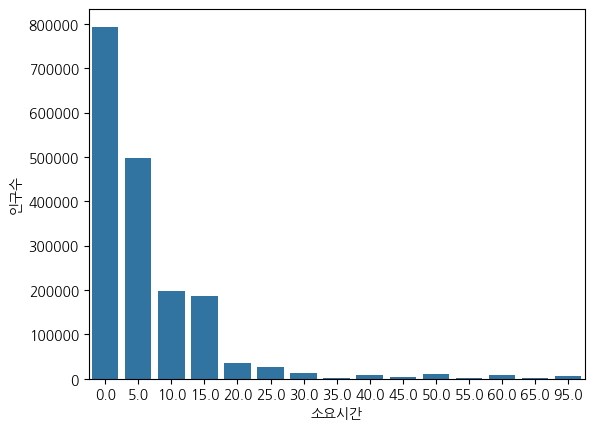

In [15]:
comm_pop_jeonnam["bin"] = comm_pop_jeonnam["소요시간"].map(lambda x: 5 * (x // 5))

fig, ax = plt.subplots()
plt.rcParams["font.family"] = "Nanum Gothic"
sns.barplot(x="bin", y="인구수", data=comm_pop_jeonnam.groupby("bin")["인구수"].sum().reset_index(), ax=ax)
ax.set_xlabel("소요시간")
fig.show()

In [16]:
tk = ["대구", "경북"]
comm_pop_tk = comm_pop_df[comm_pop_df["시도"].isin(tk)]
emergency_tk = emergency_df[emergency_df["시도"].isin(tk)]

fig, f_map = create_white_background_map(center_loc=[36.3, 128.7], zoom_start=8)
add_residential_layer(f_map, res_df=comm_pop_tk, radius_weight=0.1)
add_emergency_layer(f_map, er_df=emergency_tk, radius_weight=0.5)
display(fig)

In [17]:
nearest_info_list = list()
for row in tqdm(comm_pop_tk.itertuples(), total=comm_pop_tk.shape[0]):
    lon = getattr(row, "경도")
    lat = getattr(row, "위도")
    nearest_info = ne.get_nearest_er(lon, lat)
    nearest_info_list.append(nearest_info)

nearest_info_df = pd.DataFrame(nearest_info_list)
nearest_info_df.rename({
    "hpid": "최근접_hpid",
    "기관명": "최근접_기관명", 
    "주소": "최근접_주소", 
    "경도": "최근접_경도", 
    "위도": "최근접_위도",
}, axis=1, inplace=True)
comm_pop_tk.reset_index(drop=True, inplace=True)
comm_pop_tk2 = pd.concat([comm_pop_tk, nearest_info_df], axis=1)

  0%|          | 0/472 [00:00<?, ?it/s]

In [23]:
comm_pop_tk2.to_csv("../data/processed/nearest_er_tk.csv", index=False)

# joined_tk2 = pd.read_csv("../data/processed/nearest_er_tk.csv")
# joined_tk2

In [19]:
comm_pop_gyeongbuk = comm_pop_tk2[comm_pop_tk2["시도"] == "경북"]

fig, f_map = create_white_background_map(center_loc=[36.3, 128.7], zoom_start=8)
add_nearest_er_line_layer(f_map, nearest_er_df=comm_pop_gyeongbuk, color="red", linewidth=1)
display(fig)

/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_8709/2587237068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_pop_gyeongbuk["bin"] = comm_pop_gyeongbuk["소요시간"].map(lambda x: 5 * (x // 5))
/var/folders/zk/35s80sbd2sx1mxbrymjjqqf80000gn/T/ipykernel_8709/2587237068.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


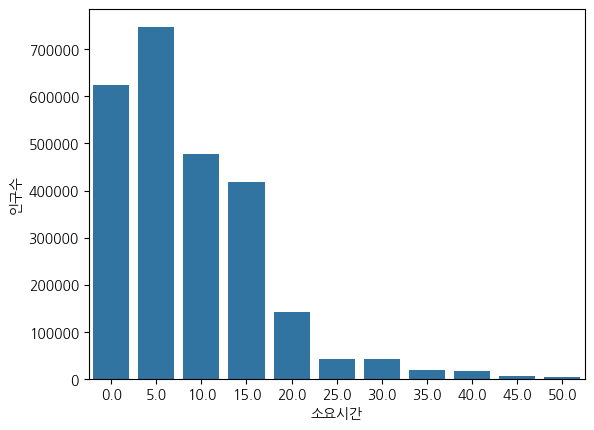

In [20]:
comm_pop_gyeongbuk["bin"] = comm_pop_gyeongbuk["소요시간"].map(lambda x: 5 * (x // 5))

fig, ax = plt.subplots()
plt.rcParams["font.family"] = "Nanum Gothic"
sns.barplot(x="bin", y="인구수", data=comm_pop_gyeongbuk.groupby("bin")["인구수"].sum().reset_index(), ax=ax)
ax.set_xlabel("소요시간")
fig.show()